In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from common_module import *
from plotting_module import *
import warnings

In [2]:
%matplotlib qt

set_matplotlib_defaults()

warnings.filterwarnings('ignore')

tf.keras.backend.set_floatx('float64')

In [3]:
# Load parameters
with open('../parameters.json', 'r') as f:
   parameters = json.load(f)['parameters']

parameters

{'R_lc': 16.67,
 'r_c': 13.336,
 'Pc_mode': 'free',
 'Pc_fixed': 0.075284943,
 'sep_width': 0.005,
 'coordinates': 'spherical',
 'n_1': 450,
 'n_2': 450,
 'extent': 3,
 'deriv_mode': 'fd'}

In [4]:
# Grid
r, theta, q, mu, rho, z = get_grid(parameters)

if parameters['coordinates'] == 'spherical':

    x1, x2 = r, theta
    X, Z = r*np.sin(theta), r*np.cos(theta)

elif parameters['coordinates'] == 'compactified':

    x1, x2 = q, mu
    X, Z = np.sqrt(1 - mu **2) * q, mu * q

elif parameters['coordinates'] == 'cylindrical':

    x1, x2 = rho, z
    X, Z = rho, z

# PINN input
X_test = generate_test (x1, x2, parameters)

In [5]:
# Load trained network
tf.keras.utils.get_custom_objects()['AdaptiveActivation'] = AdaptiveActivation
N_p = tf.keras.models.load_model("../data/N_P.h5", compile=False)
N_t = tf.keras.models.load_model("../data/N_T.h5", compile=False)


# Calculate the scalar functions
P, Pc, T, T_prime, dP_dx1, dP_dx2, d2P_dx12, d2P_dx22, d2P_dx1dx2, d2P_dx2dx1 = get_scalar_functions(X_test, N_p, N_t, parameters)

# # Calculate the elements of the parametrisation
Np, Nt, fb, hb = get_pinn (X_test, P, Pc, N_p, N_t, parameters)

# Calculate magnetic and electric fields and related quantities
B_1, B_2, B_3, \
E_1, E_2, E_3, \
B_mag, E_mag, B_pol, \
E_dot_B, div_B, div_E = get_fields (x1, x2, P, T, dP_dx1, dP_dx2, d2P_dx12, d2P_dx22, d2P_dx1dx2, d2P_dx2dx1, parameters)

# # Calculate the Pulsar Equation
pulsar_eq = pulsar_equation (x1, x2, dP_dx1, dP_dx2, d2P_dx12, d2P_dx22, T, T_prime, parameters)

In [6]:
# Generate analysis plots
plot_scalar_functions(X, Z, P, Pc, T, T_prime, parameters)
plot_pinn (X, Z, P, Pc, fb, hb, Np, parameters)
plot_fields (X, Z, P, Pc, B_mag, E_mag, div_E, parameters)
plot_pulsar_equation(X, Z, pulsar_eq, P, Pc, parameters)
# plot_T_of_P (P, Pc, T, T_prime, parameters)

In [14]:
pulsar_eq[1:-1,1:-1][np.isfinite(pulsar_eq[1:-1,1:-1])].max()

0.04060921571936562

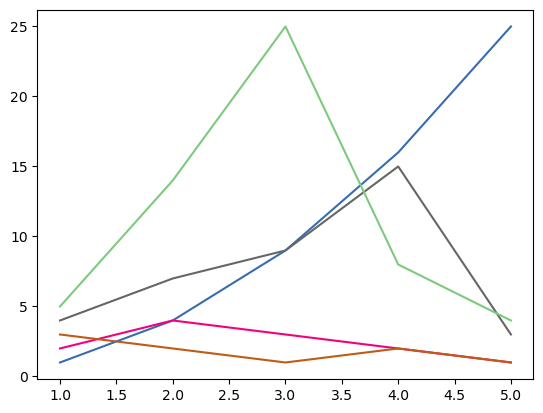

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Set the default color cycle
custom_colors = ['steelblue', 'firebrick', 'mediumseagreen', 'darkslategray', 'mediumorchid']
custom_colors = ['#386cb0', '#f0027f', '#bf5b17', '#666666', '#7fc97f', '#beaed4', '#fdc086', '#ffff99']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Now when you create plots, the default color cycle will be from "tab10"
plt.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
plt.plot([1, 2, 3, 4, 5], [2, 4, 3, 2, 1])
plt.plot([1, 2, 3, 4, 5], [3, 2, 1, 2, 1])
plt.plot([1, 2, 3, 4, 5], [4, 7, 9, 15, 3])
plt.plot([1, 2, 3, 4, 5], [5, 14, 25, 8, 4])


plt.show()